In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch

from spaceoracle.models.estimators import ViTEstimatorV2, device
import spaceoracle
from spaceoracle import SpaceOracle

In [4]:
# from utils import adata_train, adata_test

In [5]:
adata_train = sc.read_h5ad('./.cache/adata_train.h5ad')
adata_test = sc.read_h5ad('./.cache/adata_test.h5ad')

In [6]:
def clean_up_adata(adata):
    fields_to_keep = ['cluster', 'rctd_cluster']
    current_obs_fields = adata.obs.columns.tolist()
    excess_obs_fields = [field for field in current_obs_fields if field not in fields_to_keep]
    for field in excess_obs_fields:
        del adata.obs[field]
    
    current_var_fields = adata.var.columns.tolist()
    excess_var_fields = [field for field in current_var_fields 
        if field not in []]
    for field in excess_var_fields:
        del adata.var[field]

    del adata.uns

In [7]:
clean_up_adata(adata_train)
clean_up_adata(adata_test)

In [8]:
# sc.pl.embedding(
#     adata_train, color=target_gene, basis='spatial', 
#     layer='normalized_count', cmap='viridis')

# sc.pl.embedding(
# adata_train, color=target_gene, basis='spatial', 
# layer='imputed_count', cmap='viridis')

In [32]:
target_gene = 'Pax5'

In [10]:
# estimator2 = ViTEstimatorV2(adata_train, target_gene=target_gene, layer='imputed_count')

# estimator2.fit(
#     annot='rctd_cluster', 
#     max_epochs=10, 
#     learning_rate=3e-4, 
#     spatial_dim=64,
#     batch_size=128,
#     init_betas='co',
#     mode='train_test',
#     rotate_maps=True,
#     cluster_grn=True,
#     regularize=False,
#     n_patches=4, n_heads=2, n_blocks=4, hidden_d=16
# )

In [33]:
estimator = ViTEstimatorV2(adata_train, target_gene=target_gene, layer='imputed_count')

estimator.fit(
    annot='rctd_cluster', 
    max_epochs=13, 
    learning_rate=7e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    cluster_grn=True,
    regularize=False,
    n_patches=4, n_heads=2, n_blocks=4, hidden_d=16
)

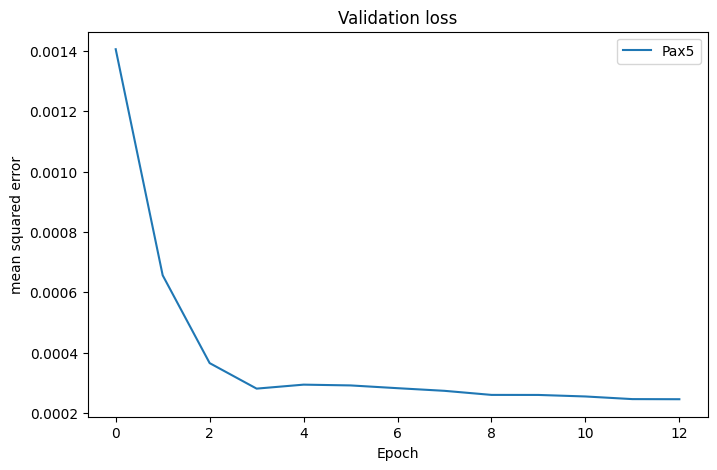

In [34]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses, label=target_gene)
# plt.plot(estimator2.losses, label='co')
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title('Validation loss')
plt.legend()
plt.show()

In [35]:
est = estimator

In [36]:
with torch.no_grad():
    betas = est.get_betas(
        spatial_maps=np.array(adata_train.obsm['spatial_maps']),
        labels=np.array(adata_train.obs['rctd_cluster']),
    )

    y_pred = est.predict_y(
        est.model, 
        torch.from_numpy(betas).to(device), 
        torch.from_numpy(
            adata_train.to_df(layer=est.layer)
            [est.regulators].values.astype(np.float32)).to(device)).cpu().numpy()

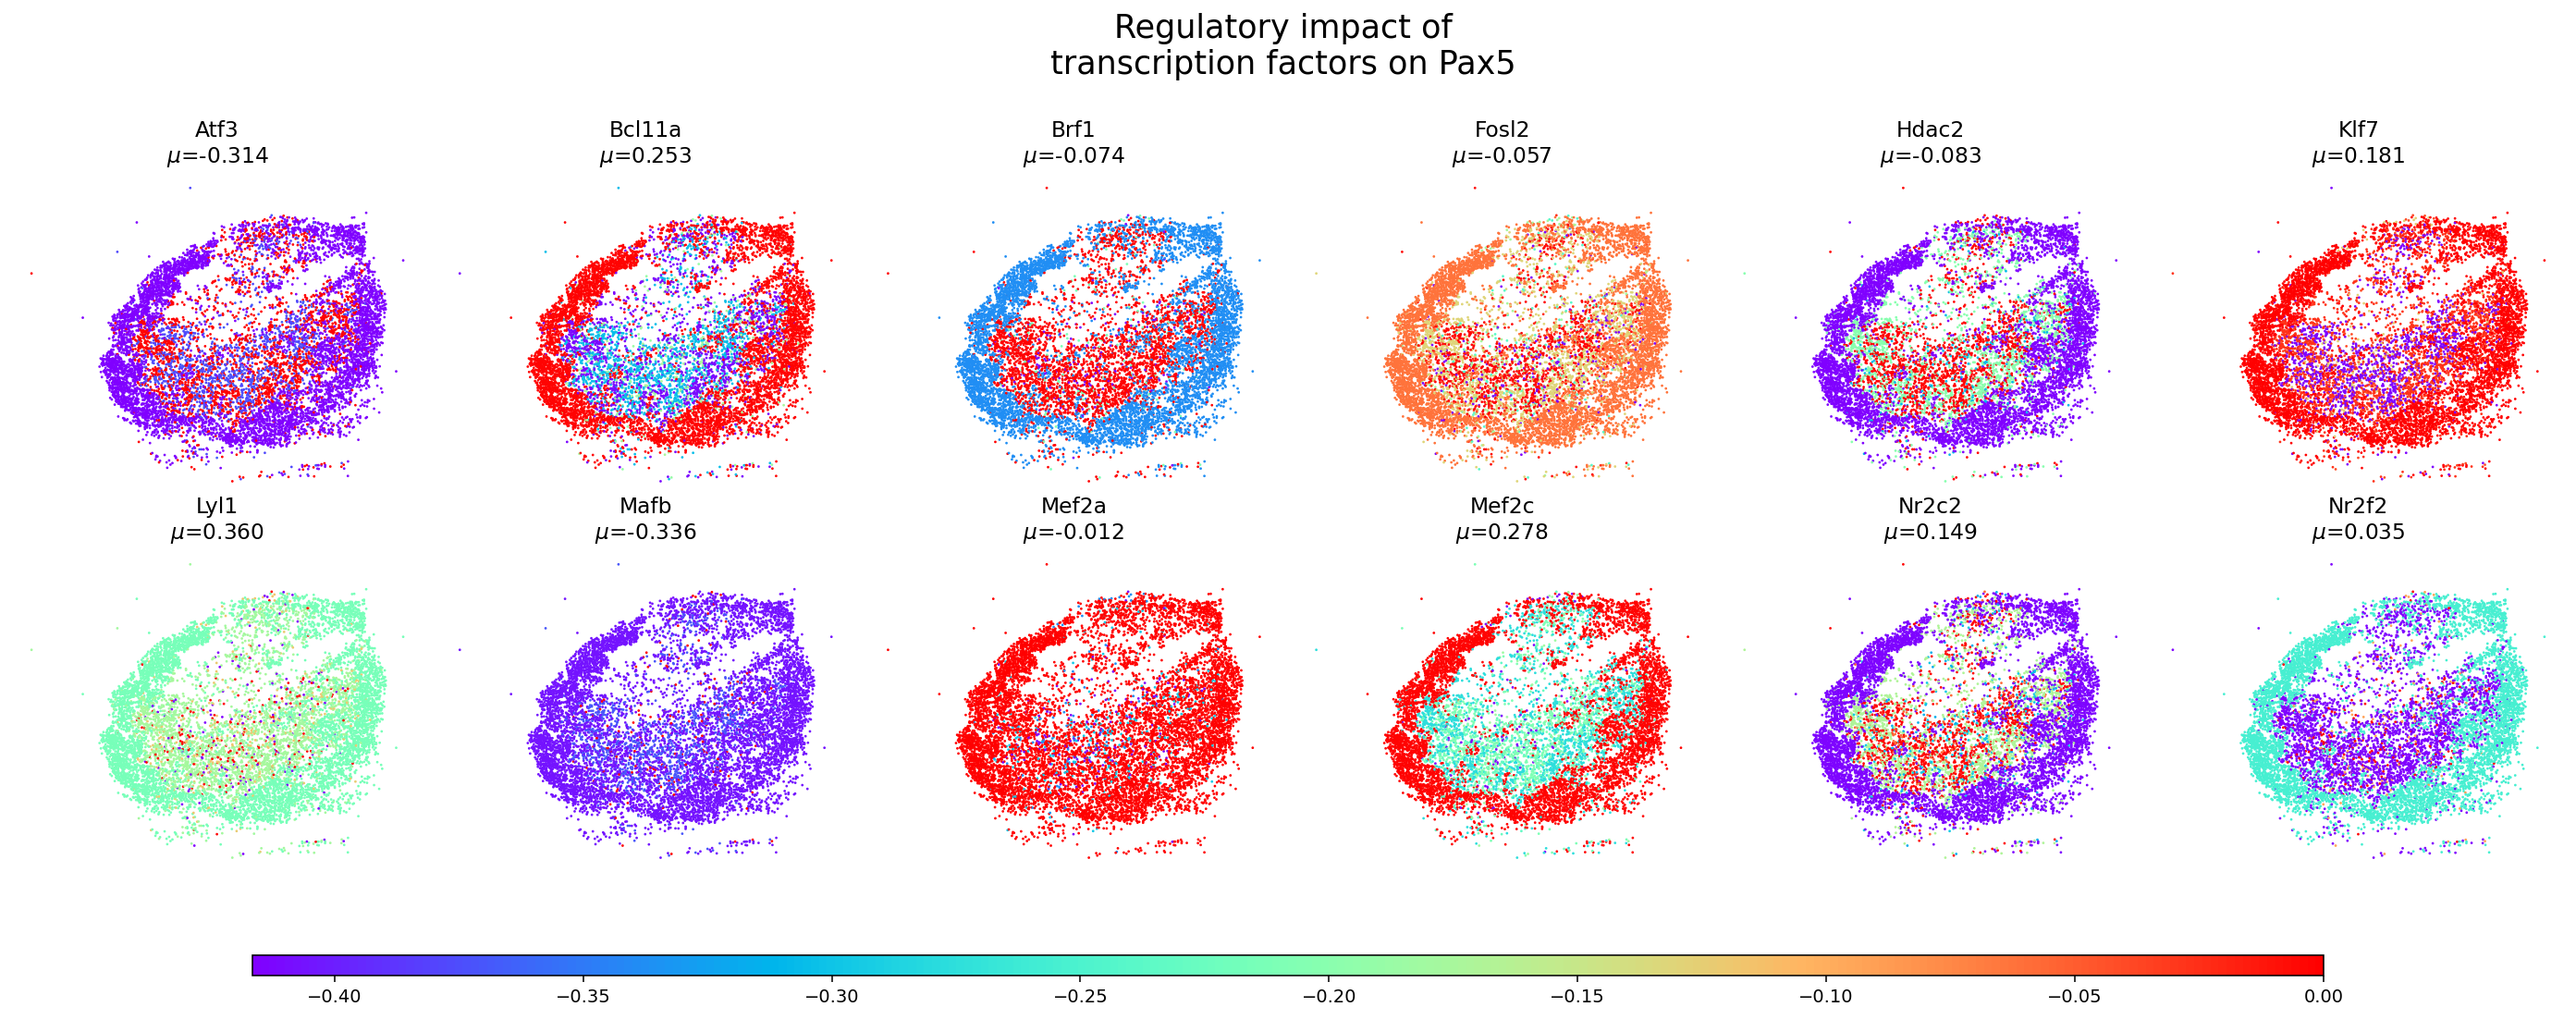

In [37]:
f, axs = plt.subplots(2, 6, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata_train.obsm['spatial'][:, 0], y=adata_train.obsm['spatial'][:, 1], 
                s=2, c=betas[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {est.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

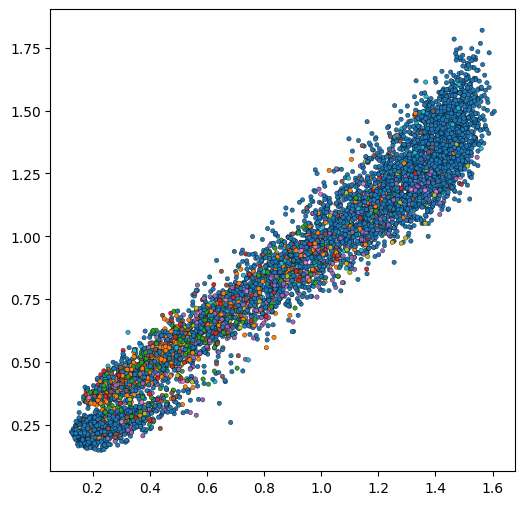

In [16]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100

y = adata_train.to_df(layer=est.layer)[[target_gene]]

sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_train.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)

# plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
# plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.show()

In [17]:
with torch.no_grad():
    betas_test = est.get_betas(
        spatial_maps=np.array(adata_test.obsm['spatial_maps']),
        labels=np.array(adata_test.obs['rctd_cluster']),
    )
    
    y_pred = est.predict_y(
        est.model, 
        torch.from_numpy(betas_test).to(device), 
        torch.from_numpy(
            adata_test.to_df(est.layer)
            [estimator.regulators].values.astype(np.float32)).to(device)).cpu().numpy()

In [22]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

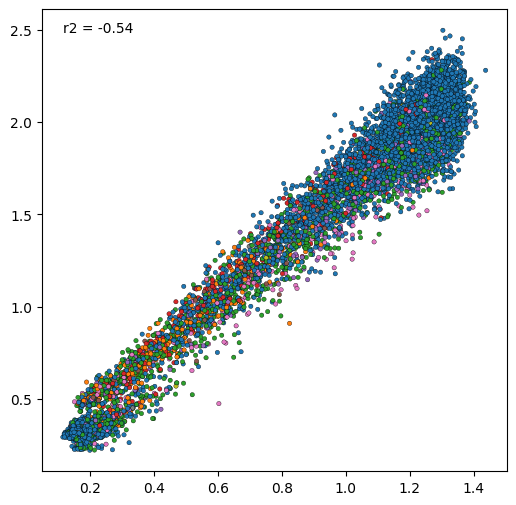

In [23]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = adata_test.to_df(layer=est.layer)[[target_gene]]
sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_test.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)
# plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
# plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)

r2 = r2_score(y.values.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.values.min(), 
    y=y_pred.max()+0.05, 
    s=f'r2 = {r2:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()


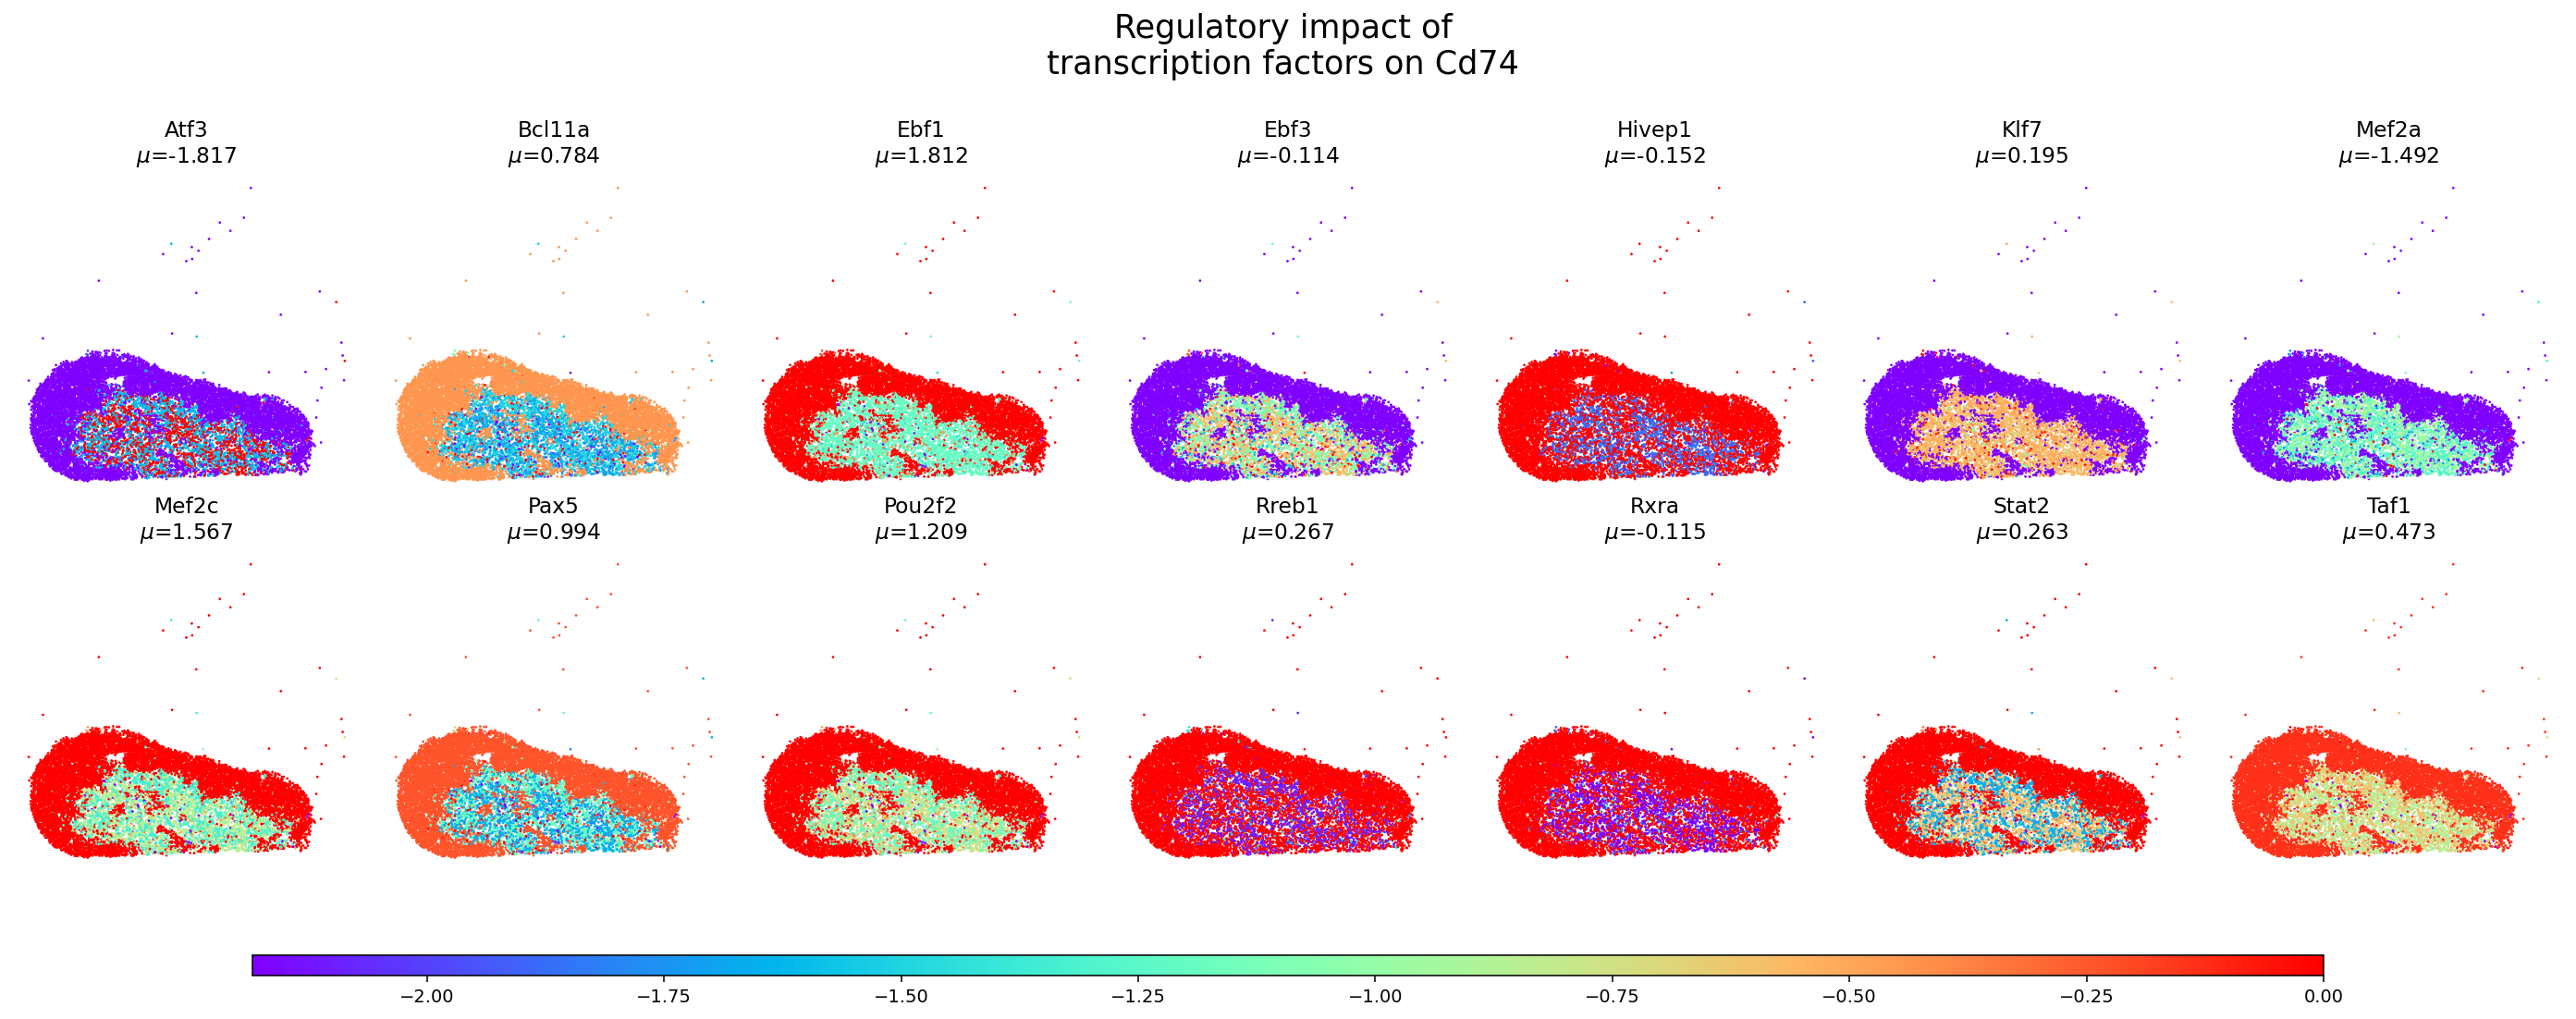

In [24]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata_test.obsm['spatial'][:, 0], y=adata_test.obsm['spatial'][:, 1], 
                s=2, c=betas_test[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas_test.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

In [25]:
# Examine attention weights

train_dataloader, valid_dataloader = estimator._build_dataloaders_from_adata(
    est.adata.copy(), est.target_gene, est.regulators, batch_size=1, mode='train', 
    rotate_maps=False, annot='rctd_cluster', spatial_dim=64)


for batch_spatial, batch_x, batch_y, batch_labels in valid_dataloader:
    break

In [26]:
est.model

VisionTransformer(in_channels=7, spatial_dim=64, n_patches=4, n_blocks=4, hidden_d=16, n_heads=2)

In [27]:
att_weights = est.model.get_att_weights(batch_spatial.to(device))
att_weights[0][0].shape # (nblocks, batch, nheads, patch, patch)

torch.Size([2, 17, 8])

In [29]:
att_weights[1][0][i].mean(dim=1).squeeze(0).detach().cpu().numpy()[1:].shape

(16,)

IndexError: index 2 is out of bounds for dimension 0 with size 2

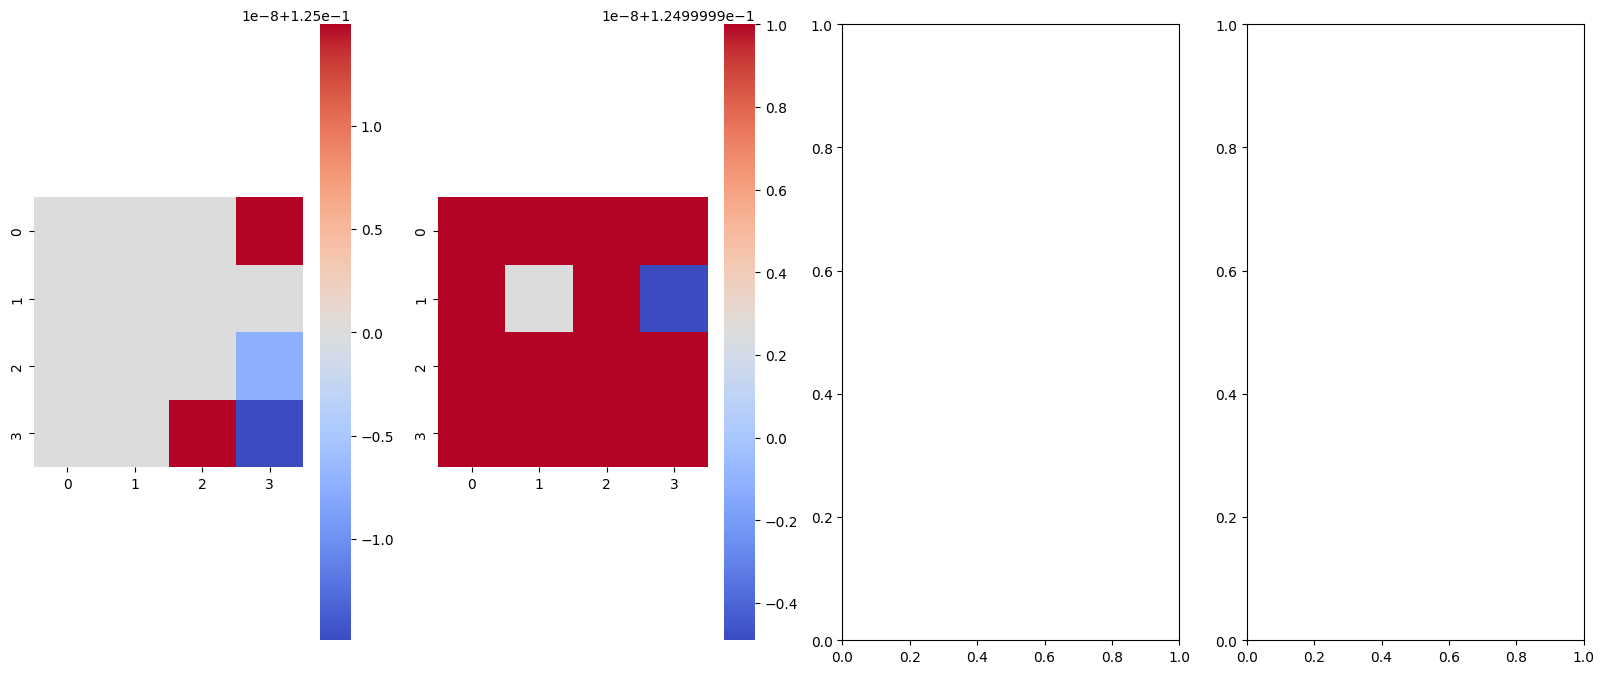

In [31]:
n_blocks = estimator.model.n_blocks
fig, axs = plt.subplots(ncols=n_blocks, figsize=(20, 8))

# (nblocks, batch, nheads, patch, patch)

for i in range(4):
    sns.heatmap(att_weights[1][0][i].mean(dim=1).squeeze(0).detach().cpu().numpy()[1:].reshape(4,4), 
                ax=axs[i], cmap='coolwarm', square=True)

<AxesSubplot: >

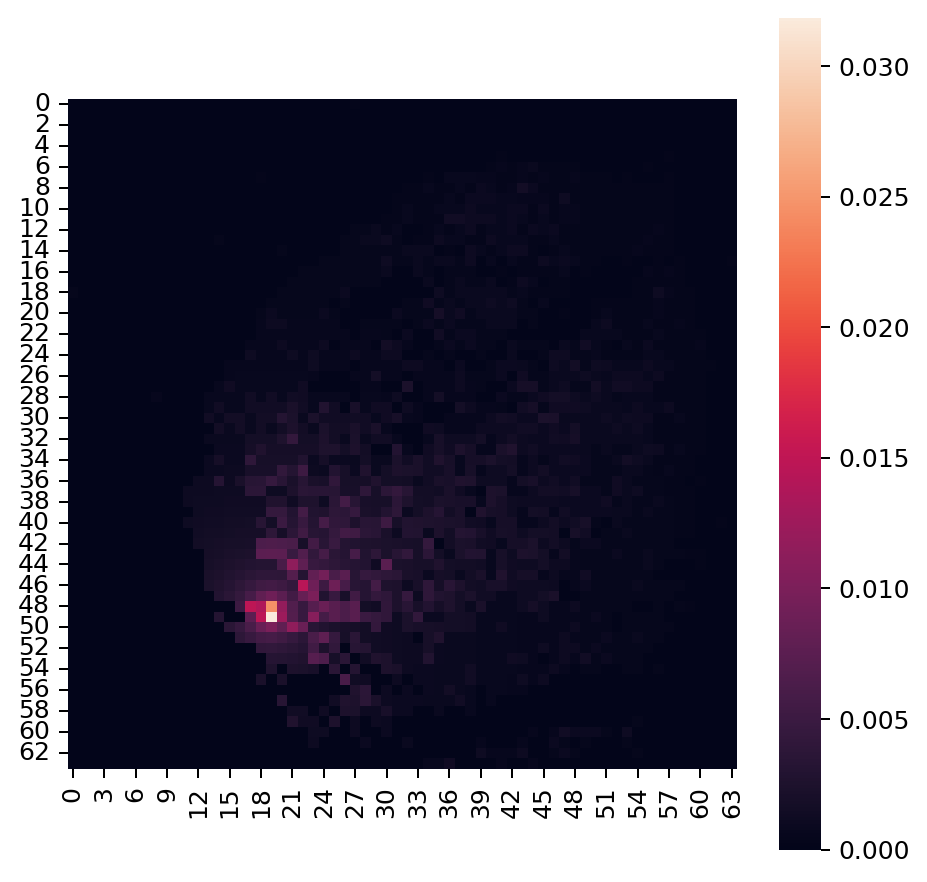

In [25]:
sns.heatmap(batch_spatial.sum(axis=1).squeeze().detach().cpu().numpy(), square=True)